In [70]:
import os, sys
from pathlib import Path
import torch
import tifffile as tiff

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 50
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [71]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
pca = test['pca']

img_names = test['img_names']

In [72]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [73]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [74]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [75]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [76]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

In [77]:
print(img_names[247], img_names[248])

00247_-0.253_S_-1.014_D_2.431_B.tiff 00248_0.455_S_0.342_D.tiff


In [78]:
img_names[247]

'00247_-0.253_S_-1.014_D_2.431_B.tiff'

In [79]:
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB
from monai.transforms import Compose, ToTensor
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])

In [ ]:
import SimpleITK as sitk
import numpy as np
import torch

save_name = f'data/{exp_name}/cntr/'
cf_vals = {1:1}
image_shape = (180, 180)  # Assuming each image is 180x180

# rands = np.random.randint(0, encoded_data.shape[0], nsamples)
# d_obs = test_imgs[rands, :]
# encoded_obs = encoded_data[rands, :]
# 
# names = img_names[rands]
# dis_obs = disease[rands]
# bias_obs = bias[rands]
residuals = test_imgs - pca.inverse_transform(encoded_data)

cf = np.zeros((251, ncomps))
for ev in range(0, ncomps - nbasecomps, nevecs - nbasecomps):
    ed = encoded_data[248:, ev:ev + nevecs]
    X_obs = np.hstack([disease[248:, np.newaxis], bias[248:, np.newaxis], ed])
    try:
        macaw = torch.load(model_base_path / f'{ev}.pt')
        cc = macaw.counterfactual(X_obs, cf_vals)
    except Exception as e:
        print(e, "Using original")
        cc[:, ncauses:] = X_obs[:, ncauses:].copy()

    cf[:, ev:ev + nevecs] = cc[:, ncauses:]

re_cf = recons(cc[:, 0], cc[:, 1], cf)
re_cf_resd = re_cf[2] + residuals[248:]

# Convert numpy arrays to SimpleITK images
def numpy_to_sitk(img):
    return sitk.GetImageFromArray(img.astype(np.float32))

def sitk_to_numpy(img):
    return sitk.GetArrayFromImage(img)

# Perform histogram matching
matched_images = []
for i in range(251):
    # Reshape the arrays to 2D images
    source_img_2d = re_cf_resd[i].reshape(image_shape).astype(np.float32)
    reference_img_2d = test_imgs[i].reshape(image_shape).astype(np.float32)
    
    source_img = numpy_to_sitk(source_img_2d)
    reference_img = numpy_to_sitk(reference_img_2d)
    
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(500)
    matcher.SetNumberOfMatchPoints(50)
    matcher.SetThresholdAtMeanIntensity(False)
    matched_img = matcher.Execute(source_img, reference_img)
    
    # Convert the matched image back to a numpy array and reshape to original shape
    matched_img_array = sitk_to_numpy(matched_img).reshape(-1)
    matched_images.append(matched_img_array)

# Convert the matched images back to a numpy array
re_cf_resd = np.array(matched_images)

# Ensuring values are still in the range [0, 1] after histogram matching
# re_cf_resd = np.clip(re_cf_resd, 0, 1)

# Continue with the rest of your code as needed

diff = test_imgs[248:] - re_cf_resd

In [89]:
nob_gt=[]
farb_gt=[]

for i in range(251):
    nob_gt = tiff.imread('no_bias/test/'+img_names[i])
    nob_gt = transforms(nob_gt)
    
    farb_gt = tiff.imread('far_bias/test/'+img_names[i])
    farb_gt = transforms(farb_gt)

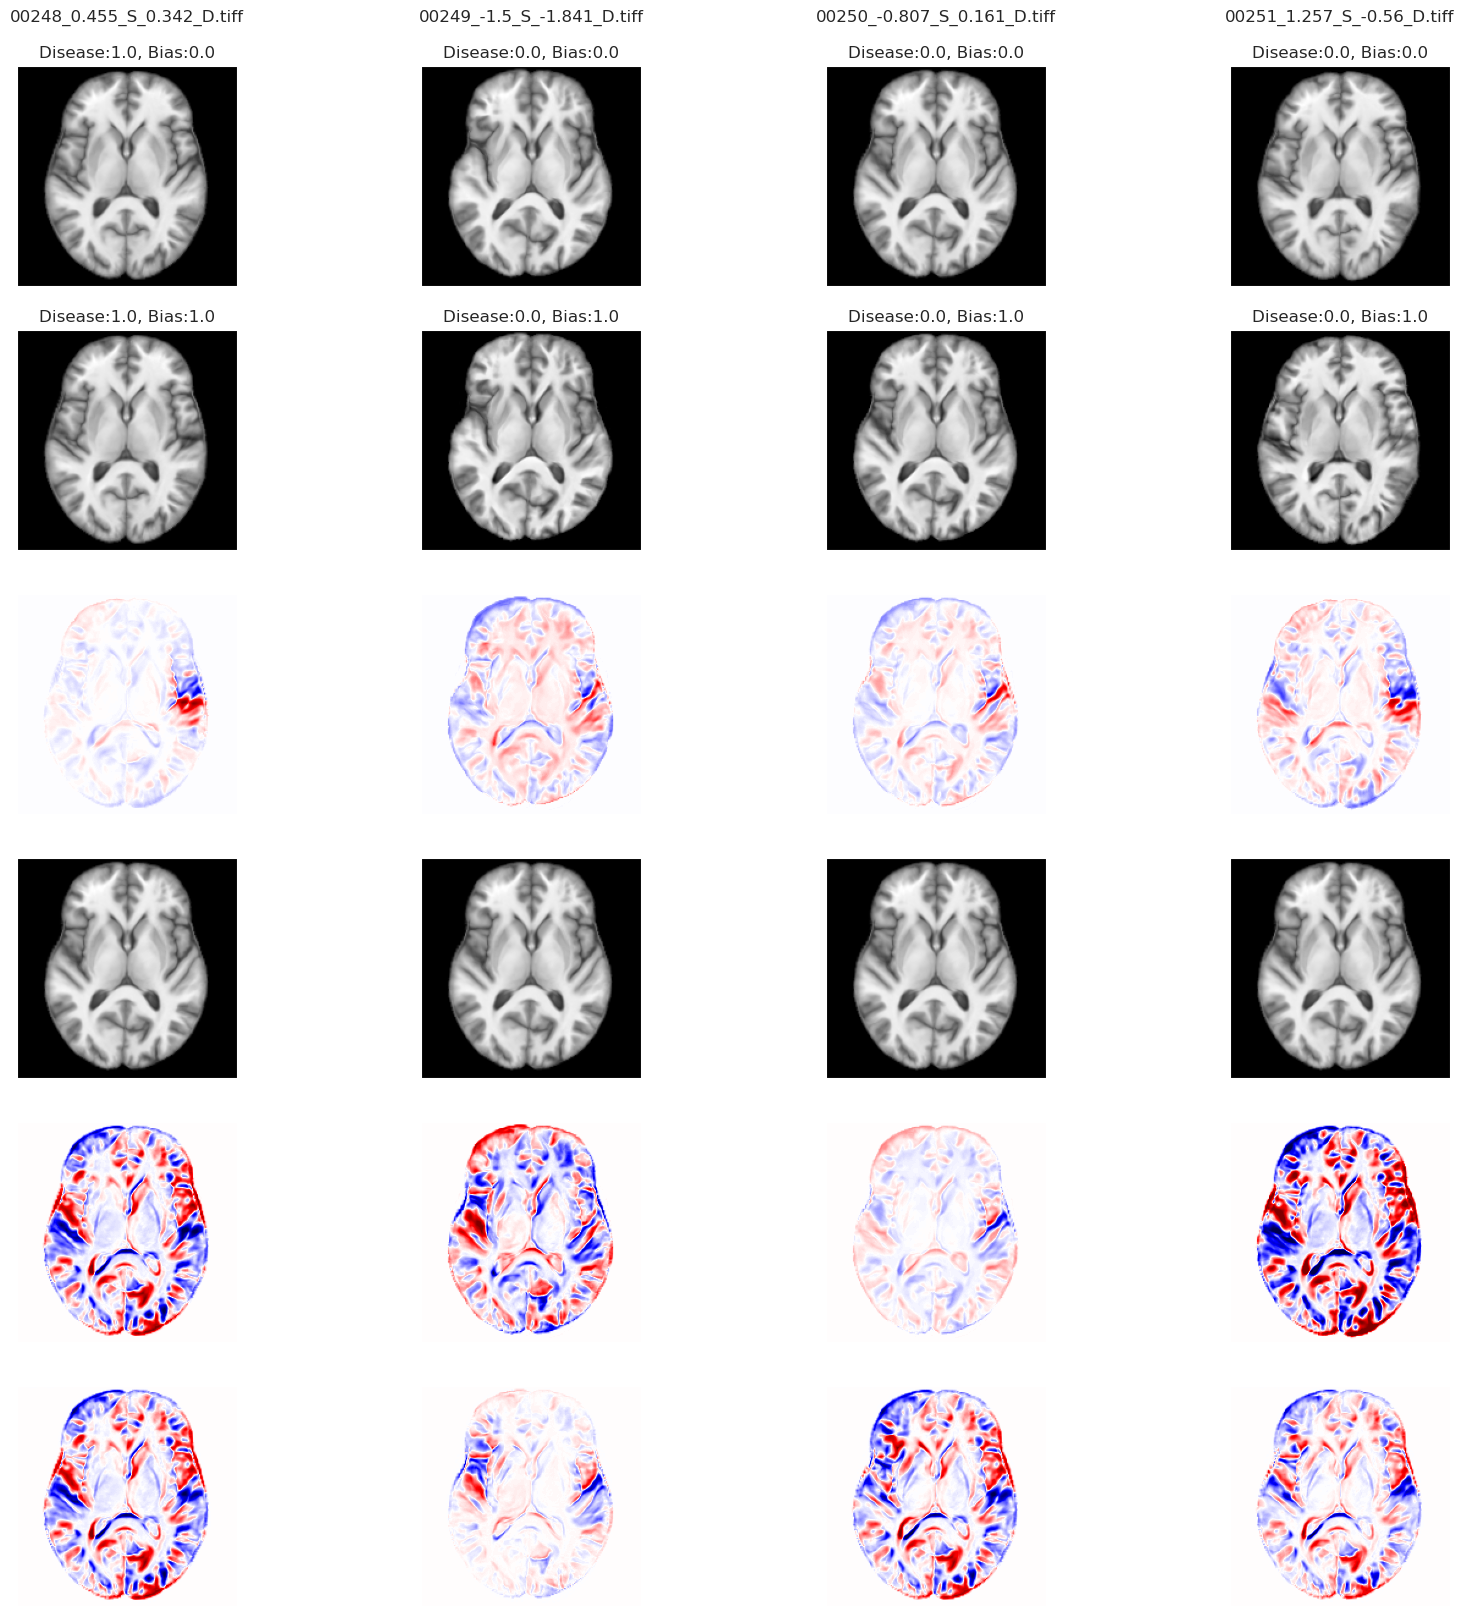

In [90]:
fig,axs = plt.subplots(6,4, figsize=(20,20))

lim=0.5
lims=(-lim,lim)

for i in range(4):
    axs[0,i].imshow(test_imgs[248+i].reshape(crop_size,crop_size),cmap='gray')
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'{img_names[248+i]}\n\nDisease:{X_obs[i,0]}, Bias:{X_obs[i,1]}')

    axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
    axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{cc[i,0]}, Bias:{cc[i,1]}')

    axs[2,i].imshow(diff[i].reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    t = pca.transform(img.reshape(1,-1))
    X_recon = pca.inverse_transform(t)
    
    axs[3,i].imshow(    X_recon.reshape(crop_size,crop_size),cmap='gray')
    axs[3,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # diff between cf no_bias and ground truth no_bias, ideally would have no difference
    axs[4,i].imshow((re_cf_resd[i].reshape(crop_size,crop_size)) -     X_recon.reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[4,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # shows the bias Emma added
    axs[5,i].imshow(test_imgs[i].reshape(crop_size,crop_size) -     X_recon.reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[5,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
if not os.path.exists(save_name):
    os.makedirs(save_name)

plt.savefig(save_name+f"cf1.pdf")
plt.show()